# Analyze SAXS Data on Nanoparticles in Water

The following code analyzes SAXS data on 50 +/- 3 nm SiO2 nanoparticles dispersed in water obtained during beamtime from 3/27/19-4/1/19 at the Argonne Photon Source (APS).

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

import saxs

from importlib import reload
reload(saxs)

# PARAMETERS
data_folder_path = '..\\..\\EXPERIMENTS\\APS\\APS_NP_MF_DEVICE\\SAXS\\flow\\'
filename_structure = 'flow_hs104_*.tif'

## Load Data

We first load the images of SAXS patterns from the data.

(380, 2011)
(380, 2011)


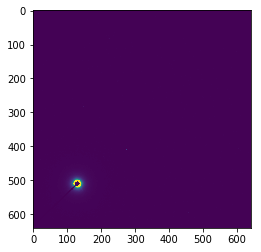

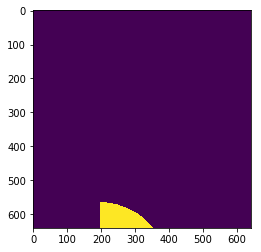

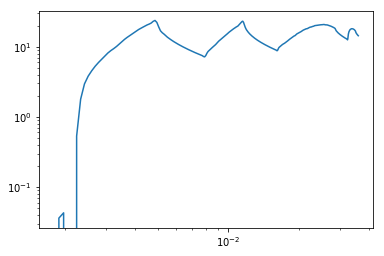

In [110]:
# Get file path
filepath_structure = os.path.join(data_folder_path,filename_structure)
file_list = glob.glob(filepath_structure)

# loop through images
for file in file_list[0:1]:
    file = os.path.join(data_folder_path,'flow_hs104_183_0001.tif')
    scan, frame = saxs.parse_filename(file)
    im = plt.imread(file)
    # analyze I vs. q
    intensity, q = saxs.average_intensity_1d(im, 'phi', phi_lim=(-np.pi/2,0), show_roi=True)
    plt.figure()
    plt.loglog(q, intensity)

In [ ]:
q